<a href="https://colab.research.google.com/github/KassyXu/PhasedLSTM-Keras/blob/master/scratchpad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
stable = True # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

In [2]:
from tsai.all import *
my_setup()

os              : Linux-5.10.147+-x86_64-with-glibc2.29
python          : 3.8.10
tsai            : 0.3.5
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.13.1+cu116
device          : cpu
cpu cores       : 1
threads per cpu : 2
RAM             : 12.68 GB
GPU memory      : N/A


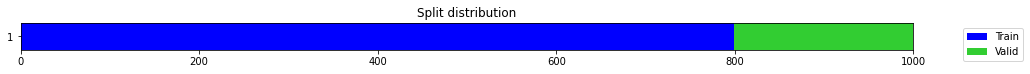

In [3]:
X = np.random.rand(1_000, 16, 100)
labels = alphabet[:12]
multi_y = np.array([labels[list(set(np.random.randint(0, 12, np.random.randint(1, 5))))] for _ in range(1_000)])
splits = TimeSplitter()(multi_y)

In [4]:
tfms  = [None, TSMultiLabelClassification()] # TSMultiLabelClassification() == [MultiCategorize(), OneHotEncode()]
batch_tfms = TSStandardize()
bs = 64
dls = get_ts_dls(X, multi_y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=bs)
dls.dataset

(#800) [(TSTensor(vars:16, len:100, device=cpu, dtype=torch.float32), TensorMultiCategory([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])), (TSTensor(vars:16, len:100, device=cpu, dtype=torch.float32), TensorMultiCategory([0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])), (TSTensor(vars:16, len:100, device=cpu, dtype=torch.float32), TensorMultiCategory([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.])), (TSTensor(vars:16, len:100, device=cpu, dtype=torch.float32), TensorMultiCategory([0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.])), (TSTensor(vars:16, len:100, device=cpu, dtype=torch.float32), TensorMultiCategory([1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.])), (TSTensor(vars:16, len:100, device=cpu, dtype=torch.float32), TensorMultiCategory([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.])), (TSTensor(vars:16, len:100, device=cpu, dtype=torch.float32), TensorMultiCategory([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])), (TSTensor(vars:16, len:100, device=cpu, dtype=torch.fl

epoch,train_loss,valid_loss,accuracy_multi,accuracy_multi,time
0,0.709983,0.659507,0.000000,0.609583,01:00


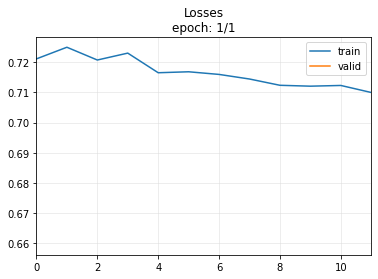

not enough values to plot a chart


In [5]:
learn = ts_learner(dls, TSTPlus, 
                   d_model=256, n_layers=6, d_ff=512, n_heads=8, dropout=0.4,
                   metrics=[partial(accuracy_multi, by_sample=True), partial(accuracy_multi, by_sample=False)], cbs=[ShowGraph(), SaveModel()])
learn.fit_one_cycle(1, lr_max=1e-3)

In [6]:
learn.load('model')
learn.validate()

not enough values to plot a chart


(#3) [0.6595067381858826,0.0,0.6095833778381348]

In [7]:
x = X[-25:]
# I pass an X with 3 dimensions [batch_size x n_vars x seq_len]
results = learn.get_X_preds(x)
results

(TensorBase([[0.3109, 0.7256, 0.5780, 0.5151, 0.4259, 0.4853, 0.4108, 0.4532,
              0.3085, 0.4498, 0.5660, 0.4413],
             [0.4093, 0.4637, 0.4091, 0.4349, 0.5874, 0.6436, 0.3945, 0.6671,
              0.5193, 0.6159, 0.5721, 0.5302],
             [0.5358, 0.1966, 0.1514, 0.2395, 0.4475, 0.3316, 0.1210, 0.1039,
              0.2520, 0.3449, 0.3567, 0.4126],
             [0.4343, 0.4078, 0.2944, 0.2823, 0.2917, 0.2423, 0.2700, 0.2698,
              0.6641, 0.3730, 0.4864, 0.2399],
             [0.2343, 0.3305, 0.2811, 0.2981, 0.1820, 0.5591, 0.2679, 0.2336,
              0.4379, 0.4763, 0.2785, 0.2687],
             [0.5825, 0.4117, 0.4673, 0.4875, 0.4503, 0.6244, 0.4976, 0.6041,
              0.7833, 0.4744, 0.6549, 0.5070],
             [0.3759, 0.4251, 0.5677, 0.2918, 0.3303, 0.4054, 0.3747, 0.4838,
              0.6203, 0.5188, 0.4172, 0.5120],
             [0.5268, 0.6219, 0.4193, 0.5017, 0.4624, 0.3794, 0.5442, 0.5183,
              0.7063, 0.4930, 0.5906, 0.5283],


epoch,train_loss,valid_loss,time
0,0.333276,0.198422,00:36


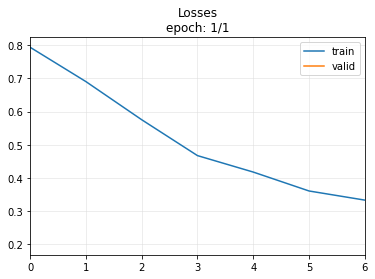

not enough values to plot a chart


In [8]:
dsid = 'ECG5000' 
X, y, splits = get_UCR_data(dsid, split_data=False)

class_map = {
    '1':['Nor'],          # N:1  - Normal
    '2':['RoT', 'Pre'],   # r:2  - R-on-T premature ventricular contraction
    '3':['PVC', 'Pre'] ,  # V:3  - Premature ventricular contraction
    '4':['SPC', 'Pre'],   # S:4  - Supraventricular premature or ectopic beat (atrial or nodal)
    '5':['Unk'],          # Q:5  - Unclassifiable beat
}
labeler = ReLabeler(class_map)
y_multi = labeler(y)

tfms  = [None, TSMultiLabelClassification()] # TSMultiLabelClassification() == [MultiCategorize(), OneHotEncode()]
batch_tfms = [TSStandardize()]
dls = get_ts_dls(X, y_multi, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=[64, 128])

learn = ts_learner(dls, InceptionTimePlus, loss_func=BCEWithLogitsLossFlat(), cbs=[ShowGraph()])
learn.fit_one_cycle(1, lr_max=1e-3)